### Домашняя работа к Уроку 2
### Студент: Абрамов А.В.

### Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [1]:
# Сделаем необходимые импорты

import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import optim
from IPython.display import clear_output
import time

In [2]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10

train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(),
                                             download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True,)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=8,
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:24<00:00, 6930151.38it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [39]:
image, label = train_dataset[7]
print(image.size())
print(label)

torch.Size([3, 32, 32])
7


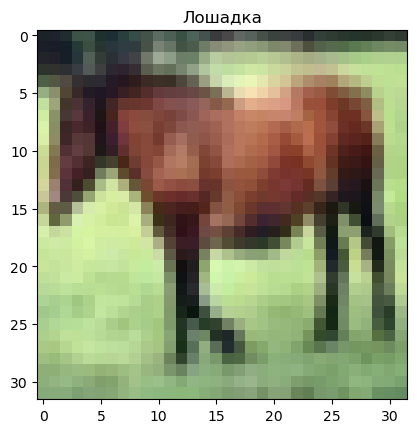

In [38]:
plt.title('Лошадка')
plt.imshow(image.permute(1, 2, 0).numpy());

In [52]:
# Создайте собственную архитектуру! Можете использовать все, что угодно,
# но в ограничении на использование линейные слои (пока без сверток)

class Neuronet(nn.Module):
    
    def __init__(self, input_n, hidden_n, output_n):
        super().__init__()
        self.fc1 = nn.Linear(input_n, 4 * hidden_n, bias=True)      # first full-connected layer
        self.fc2 = nn.Linear(4 * hidden_n, 2 * hidden_n, bias=True) # second full-connected layer
        self.fc3 = nn.Linear(2 * hidden_n, hidden_n, bias=True)     # third full-connected layer
        self.fc4 = nn.Linear(hidden_n, output_n, bias=True)         # fourth full-connected layer
        
    # Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
    # Ваша задача добавить его в архитектуру сети как функцию активации
    def leaky_relu_modif(self, x):
        return torch.max(x * 0.1, x * 0.5)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.leaky_relu_modif(x)
        x = self.fc2(x)
        x = self.leaky_relu_modif(x)
        x = self.fc3(x)
        x = self.leaky_relu_modif(x)
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.leaky_relu_modif(x)
        x = self.fc2(x)
        x = self.leaky_relu_modif(x)
        x = self.fc3(x)
        x = self.leaky_relu_modif(x)
        x = self.fc4(x)
        x = F.softmax(x)
        
def get_model(net = Neuronet(3072, 100, 10), optimizer_type = 12, show_the_learning_process = True):
    net.train()
    criterion = nn.CrossEntropyLoss()
    
    torch_optimizer = [optim.Adadelta(net.parameters(), lr=0.01),
                       optim.Adagrad(net.parameters(), lr=0.01),
                       optim.Adam(net.parameters(), lr=0.01),
                       optim.AdamW(net.parameters(), lr=0.01),
                       optim.SparseAdam(net.parameters(), lr=0.01),
                       optim.Adamax(net.parameters(), lr=0.01),
                       optim.ASGD(net.parameters(), lr=0.01),
                       optim.LBFGS(net.parameters(), lr=0.01),
                       optim.NAdam(net.parameters(), lr=0.01),
                       optim.RAdam(net.parameters(), lr=0.01),
                       optim.RMSprop(net.parameters(), lr=0.01, momentum=0.0),
                       optim.Rprop(net.parameters(), lr=0.01),
                       optim.SGD(net.parameters(), lr=0.01, momentum=0.0)]
    
    optimizer = torch_optimizer[optimizer_type]
    epochs = 5
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_items = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data[0], data[1]
        # Обнуляем градиент перед вычислением лосса и шагом обновления весов
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Вычисляем лосс-функцию на обучающей выборке
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Считаем градиент для каждого веса в нейронной сети и делаем шаг обновления весов с помощью optimizer.step()
        optimizer.step()
        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if show_the_learning_process == True:
        # Выводим статистику обучения после каждых 300 mini-batches
            if i % 300 == 0:   
                print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                      f'Step [{i + 1}/{len(train_loader)}]. ' \
                      f'Loss: {running_loss / running_items:.3f}')
                running_loss, running_items = 0.0, 0.0
    if show_the_learning_process == True:
        print('Training is finished!')
    return net


# проверка точности предсказания на обучающей выборке после обучения

def check_model(net):
    result = []
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]
        predicted = torch.max(net(inputs), 1).indices
        result.append(int((predicted == labels).sum())/len(labels))
    # Возвращаем среднюю точность предсказания
    print(f'Средняя точность составляет: {round(sum(result)/len(result), 4)}')
    return sum(result)/len(result)       

In [53]:
# Запустить обучение (по аналогии с тем, что делали на паре)

model = get_model(show_the_learning_process = True)
r = check_model(model)

Training is finished!
Средняя точность составляет: 0.1001
